## This Program Classifies Food Types

Import necessary packages

In [19]:
import matplotlib.pyplot as plt
import torch
import torchvision
import data_setup
import engine
import utils
import helper_functions

from torch import nn
from torchvision import transforms
from torchinfo import summary

# Get Data 


In [2]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [3]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [4]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataloader, test_dataloader, clas_names = data_setup.create_dataloaders(train_dir, test_dir, transforms=manual_transforms, batch_size=32)

train_dataloader, test_dataloader, clas_names

(<torch.utils.data.dataloader.DataLoader at 0x1da5932e910>,
 ['pizza', 'steak', 'sushi'])

In [6]:
# get pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # default: best available weights from pretrained model
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# auto transforms is the transformation applied to the pretrained model 
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
train_dataloader, test_dataloader, clas_names = data_setup.create_dataloaders(train_dir, test_dir, transforms=manual_transforms, batch_size=32)

train_dataloader, test_dataloader, clas_names

(<torch.utils.data.dataloader.DataLoader at 0x1da59343510>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# set up pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

In [10]:
summary(model=model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"] )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [11]:
# freeze all base layers in the 'feature' section of the model
for param in model.features.parameters():
    param.requires_grad = False
    

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# get the length of the class_names
output_shape = len(clas_names)

#recreate classifier layer 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True).to(device)
)

In [13]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# Train the model

In [14]:
# define the loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [15]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start timer 
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model, train_dataloader=train_dataloader, 
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs = 5,
                       device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:15<01:02, 15.72s/it]

Epoch: 1 | train_loss : 0.8339 | train_acc : 0.6992 | test_loss : 0.5921 | test_acc : 0.8864 | 


 40%|████      | 2/5 [00:32<00:49, 16.49s/it]

Epoch: 2 | train_loss : 0.4474 | train_acc : 0.9219 | test_loss : 0.4281 | test_acc : 0.9072 | 


 60%|██████    | 3/5 [00:47<00:31, 15.74s/it]

Epoch: 3 | train_loss : 0.2864 | train_acc : 0.9570 | test_loss : 0.3877 | test_acc : 0.8570 | 


 80%|████████  | 4/5 [01:02<00:15, 15.50s/it]

Epoch: 4 | train_loss : 0.2105 | train_acc : 0.9727 | test_loss : 0.3420 | test_acc : 0.8570 | 


100%|██████████| 5/5 [01:18<00:00, 15.61s/it]

Epoch: 5 | train_loss : 0.1618 | train_acc : 0.9805 | test_loss : 0.3097 | test_acc : 0.9176 | 
[INFO] Total training time: 78.032 seconds


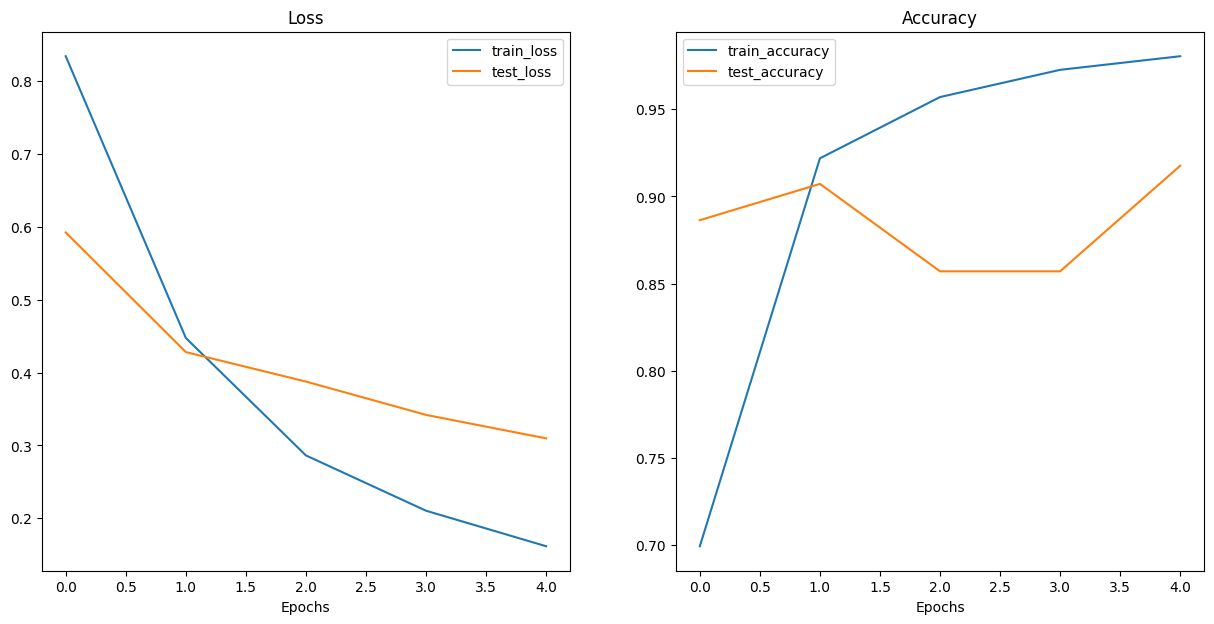

In [16]:
# Get the plot_loss_curves() function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)


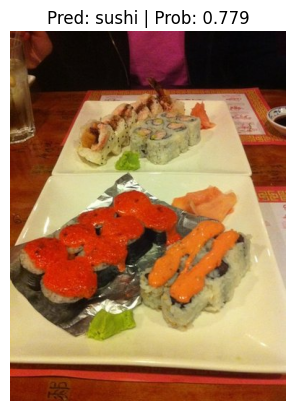

In [27]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k = num_images_to_plot)

# make predictions and plot image
for image_path in test_image_path_sample:
    helper_functions.pred_and_plot_image(model=model, image_path=image_path, class_names=clas_names)